In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

import sys
sys.path.insert(1, '../src/stproject')
from utils import *

import pickle

In [2]:
# importing feature-engineered dataset v1 (df_fe1.csv)

df_fe1 = pd.read_csv('../data/df_fe1.csv', index_col=0)

# computing new feature: molar volume (mv = M/density)
df_fe1['mv'] = df_fe1['M']/df_fe1['density']
print(len(df_fe1))
df_fe1.head()

268


,C,CH,CH2,CH3,C-ring,CH-ring,CH2-ring,C=C,C#C,Ar,...,C-O-C,CHO,CO,COOR,M,COOH,measured_st,molecule,density,mv
1,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,72.151,0.0,15.5,Pentane,0.62638,115.187267
2,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,86.178,0.0,18.0,Hexane,0.65940,130.691538
3,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.205,0.0,19.8,Heptane,0.68420,146.455715
4,0.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.232,0.0,21.1,Octane,0.70310,162.469066
5,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,128.259,0.0,22.4,Nonane,0.71760,178.733278


## Linear model for mv

In [5]:
# exclusion of samples with certain motifs due to lack of datapoints and/or irrelevance to polyester
features_exclude = ['C#C', 'C-ring', 'OH', 'CHO', 'CO', 'COOH']
df_fe1 = df_fe1[df_fe1[features_exclude].sum(axis=1) == 0]
len(df_fe1)

188

In [6]:
st = df_fe1['measured_st']
mv = df_fe1['mv']

In [8]:
X_mv = df_fe1.drop(['M', 'measured_st', 'molecule', 'density', 'mv']+features_exclude, axis=1)

lm_mv = LinearRegression()
lm_mv.fit(X_mv, mv)

mv_hat = pd.Series(lm_mv.predict(X_mv), index=X_mv.index)
regression_results(mv, mv_hat)
coef_mv = (pd.DataFrame({'var': ['intercept']+X_mv.columns.tolist(), 'coef': [lm_mv.intercept_]+list(lm_mv.coef_)}))
print(coef_mv)

explained_variance:  0.999
mean_squared_log_error:  0.0004
r2:  0.999
MAE:  1.9297
MSE:  7.0394
RMSE:  2.6532
          var       coef
0   intercept  26.928182
1           C  13.301486
2          CH  15.803600
3         CH2  16.534288
4         CH3  17.753248
5     CH-ring  13.161606
6    CH2-ring  13.210124
7         C=C  24.575174
8          Ar  60.431005
9       C-O-C   5.519402
10       COOR  20.437433


Empty DataFrame
Columns: [name, y, y_hat]
Index: []


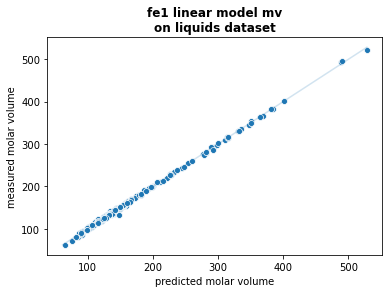

In [12]:
# plotting results with custom function
plot_results(mv, mv_hat, df_fe1['molecule'], 0,
             'fe1 linear model mv\non liquids dataset', 'predicted molar volume', 'measured molar volume')

### Linear model 0 - parachor model

In this model, surface tension (gamma) is expressed as gamma = (P/mv)^n, with <br> 
mv = M/density <br>
n = power (value of 4 is suggested by literatures)

In [17]:
n = 4
X0 = df_fe1.drop(['M', 'measured_st', 'molecule', 'density', 'mv']+features_exclude, axis=1)
y0 = (st**(1/n)) * mv

In [21]:
lm0 = LinearRegression()
lm0.fit(X0, y0)
y_hat0 = lm0.predict(X0)
st_hat0 = (y_hat0/mv)**n

regression_results(st, st_hat0)
coef0 = (pd.DataFrame({'var': ['intercept']+X0.columns.tolist(), 'coef': [lm0.intercept_]+list(lm0.coef_)}))
print(coef0)

with open('../models/fe1_lm0.pickle','wb') as modelFile:
    pickle.dump(lm0,modelFile)

explained_variance:  0.8367
mean_squared_log_error:  0.0033
r2:  0.8365
MAE:  0.9857
MSE:  2.9284
RMSE:  1.7113
          var        coef
0   intercept   35.422202
1           C   29.718480
2          CH   36.155376
3         CH2   39.225298
4         CH3   39.801181
5     CH-ring   31.776546
6    CH2-ring   33.854806
7         C=C   64.044574
8          Ar  168.315868
9       C-O-C   18.824672
10       COOR   60.995764


                              name     y      y_hat
186                  Hexyl formate  26.4  40.797187
69   1,2,3,4-Tetrahydronaphthalene  33.2  38.374707
53          1,2,3-Trimethylbenzene  28.3  33.431289
192                 Propyl acetate  23.8  18.824065
42                    Cyclopentene  22.0  26.943248


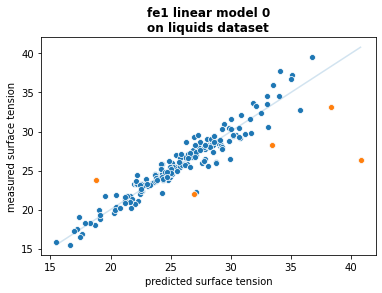

In [22]:
# plotting results with custom function
plot_results(st, st_hat0, df_fe1['molecule'], 5,
             'fe1 linear model 0\non liquids dataset', 'predicted surface tension', 'measured surface tension')

### Linear model 1 - with features (molecular fragments) normalized by M

In this model, only molecular fragments normalized (divided) by M are used as regressors.

In [23]:
X1 = (df_fe1.drop(['M', 'measured_st', 'molecule', 'density', 'mv']+features_exclude, axis=1)
                   .divide(df_fe1['M'], axis=0))
X1.head()

,C,CH,CH2,CH3,CH-ring,CH2-ring,C=C,Ar,C-O-C,COOR
1,0.0,0.0,0.041579,0.027720,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.046416,0.023208,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.049898,0.019959,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.052525,0.017508,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.054577,0.015593,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
lm1 = LinearRegression()
lm1.fit(X1, st)
y_hat1 = pd.Series(lm1.predict(X1), index=X1.index)

regression_results(st, y1_hat)
coef1 = (pd.DataFrame({'var': ['intercept']+X1.columns.tolist(), 'coef': [lm1.intercept_]+list(lm1.coef_)}))
print(coef1)

with open('../models/fe1_lm1.pickle','wb') as modelFile:
    pickle.dump(lm1,modelFile)

explained_variance:  0.8579
mean_squared_log_error:  0.0034
r2:  0.8579
MAE:  1.2105
MSE:  2.5455
RMSE:  1.5955
          var          coef
0   intercept   -452.316610
1           C   6832.075466
2          CH   6715.342903
3         CH2   6777.067641
4         CH3   6688.926417
5     CH-ring   6513.806194
6    CH2-ring   6696.667585
7         C=C  12529.061226
8          Ar  37718.713551
9       C-O-C   7908.558595
10       COOR  21786.552462


                                    name     y      y_hat
239                     Dimethyl maleate  37.7  29.761703
42                          Cyclopentene  22.0  26.537513
127                  1,2-Propylene oxide  22.2  26.470559
27                           Cyclooctane  29.3  25.096064
133  Tetraethylene glycol dimethyl ether  33.7  29.673245


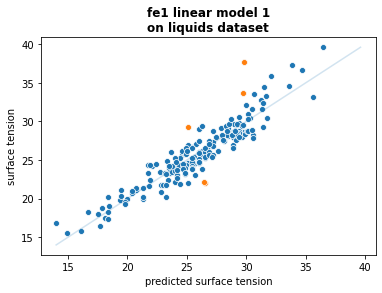

In [29]:
# plotting results with custom function
plot_results(st, y_hat1, df_fe1['molecule'], 5,
            'fe1 linear model 1\non liquids dataset', 'predicted surface tension', 'surface tension')

# Preparation of test set

In [64]:
df_test = pd.read_csv('../data/polyesters.csv')
df_diols_fe1 = pd.read_csv('../data/df_diols_fe1.csv', index_col=0)
df_acids_fe1 = pd.read_csv('../data/df_acids_fe1.csv', index_col=0)

# correcting 'H', O-alc', 'O-acid' and 'O-ester' by subtracting atom/functional group loss from condensation
# TODO: make a function for this procedure
df_diols_fe0['H'] -= 2
df_acids_fe0['H'] -= 2
df_diols_fe0['O-alc'] -= 2
df_acids_fe0['O-acid'] -= 4
df_acids_fe0['O-ester'] += 4

df_monomers_fe0 = pd.concat([df_diols_fe0, df_acids_fe0])
df_monomers_fe0

,C,H,C=C,C#C,Ar,O-alc,O-eth,O-ald,O-ket,O-acid,O-ester,R3,R4,R5,R6,R7,R8,M
diol_1,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,196.290
diol_2,8.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,144.214
diol_3,15.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,240.387
diol_4,9.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.257
diol_5,8.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.230
diol_7,5.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.149
diol_8,14.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.360
diol_9,14.0,24.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.360
diol_10,5.0,10.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.146
diol_11,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,116.160


In [65]:
monomers = df_test.columns[df_test.columns.str.contains('diol|acid')]
features = df_monomers_fe0.columns

In [66]:
df_test_fe0 = avg_monomer_features(df_test, df_monomers_fe0, monomers, features)
print(df_test_fe0)
st_test = df_test['measured_st']

         C       H    C=C  C#C     Ar  O-alc  O-eth  O-ald  O-ket  O-acid  \
0    7.206   9.128  0.149  0.0  0.249    0.0    0.0    0.0    0.0   0.000   
1   10.749  15.212  0.149  0.0  0.248    0.0    0.0    0.0    0.0   0.000   
2   10.238  16.178  0.149  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
3   10.131  15.776  0.243  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
4    7.037  11.620  0.245  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
5    6.528  10.602  0.245  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
6    5.001   7.538  0.246  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
7    6.540   9.630  0.242  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
8    6.520   9.560  0.247  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
9    6.118   8.364  0.444  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
10   4.603   6.334  0.446  0.0  0.000    0.0    0.0    0.0    0.0   0.000   
11   8.544  11.586  0.246  0.0  0.000    0.0    0.0    0.0    0.0   0.000   

### TEST 0 - Prediction with parachor method

In [67]:
X_test0 = df_test_fe0[df_test_fe0.columns.difference(['M']+features_exclude)]
mv_hat_test0 = lm_mv.predict(X_test0)
mv_hat_test0
y_hat_test0 = lm0.predict(X_test0)
(y_hat_test0/mv_hat_test0)**n

array([12.03455145, 11.81531693, 11.42981776, 11.40622805, 11.08753739,
       11.13028412, 11.31829605, 11.44421772, 11.53186445, 11.65907188,
       11.47059154, 11.37010718, 11.37010718, 11.89648433, 10.99468402,
       11.54136187, 11.98715467, 11.88977426, 11.19826287])

Text(0.5, 1.0, 'Linear Model 0\nTest')

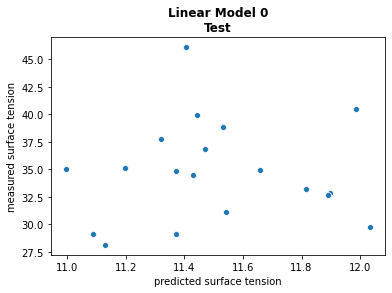

In [68]:
sns.scatterplot((y_hat_test0/mv_hat_test0)**n, st_test)
plt.xlabel('predicted surface tension')
plt.ylabel('measured surface tension')
plt.title('Linear Model 0\nTest', {'fontsize': 12, 'weight': 'bold'})

### TEST 1 - Prediction with M-normalization method

In [69]:
X_test1 = (df_test_fe0[df_test_fe0.columns.difference(['M']+features_exclude)]
           .divide(df_test_fe0['M']-18, axis=0))
y_hat_test1 = lm1.predict(X_test1)
y_hat_test1

array([-9.67047684e+14, -1.06963688e+15, -1.08776185e+15, -1.08944664e+15,
       -1.00807949e+15, -9.88551738e+14, -9.11567613e+14, -9.89658537e+14,
       -9.83006581e+14, -9.63636374e+14, -8.82137070e+14, -1.04614490e+15,
       -1.04614490e+15, -1.02825344e+15, -1.07840268e+15, -9.73190508e+14,
       -8.27236174e+14, -1.01040809e+15, -1.07098374e+15])

Text(0.5, 1.0, 'Linear Model 1\nTest')

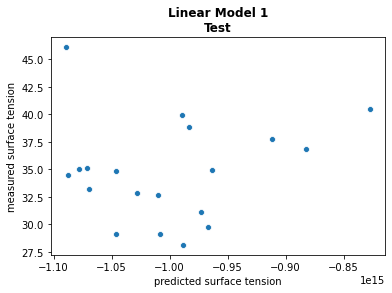

In [70]:
sns.scatterplot(y_hat_test1, st_test)
plt.xlabel('predicted surface tension')
plt.ylabel('measured surface tension')
plt.title('Linear Model 1\nTest', {'fontsize': 12, 'weight': 'bold'})

### Linear model - mvpolym

Approximation of molar volume with **polymer** data from literature

In [32]:
df_mvpolym_fe1 = pd.read_csv('../data/df_mvpolym_fe1_manual.csv', index_col=0)
len(df_mvpolym_fe1)

23

In [33]:
features_exclude_from_mv = features_exclude + ['C-ring', 'CH-ring', 'CH2-ring', 'C#C', 'OH', 'CHO', 'CO', 'COOH']
df_mvpolym_fe1 = df_mvpolym_fe1[df_mvpolym_fe1[features_exclude_from_mv].sum(axis=1) == 0]

X_mvpolym = df_mvpolym_fe1.drop(['M', 'type', 'polymer', 'measured_mv', 'measured_mv_scaled', 'ru']+features_exclude_from_mv, axis=1)
y_mvpolym = df_mvpolym_fe1['measured_mv_scaled']
lm_mvpolym = LinearRegression()
lm_mvpolym.fit(X_mvpolym, y_mvpolym)

y_hat_mvpolym = pd.Series(lm_mvpolym.predict(X_mvpolym), index=y_mvpolym.index)
regression_results(y_mvpolym, y_hat_mvpolym)

explained_variance:  0.9821
mean_squared_log_error:  0.0437
r2:  0.9821
MAE:  5.2113
MSE:  42.1892
RMSE:  6.4953


                         name      y      y_hat
6       poly(4-methylstyrene)  62.60  74.563514
1             polyisobutylene  30.70  19.234374
14  poly(methyl methacrylate)  42.05  53.515626
13      poly(propylene oxide)  29.05  18.064434
2               polypropylene  24.70  16.385978


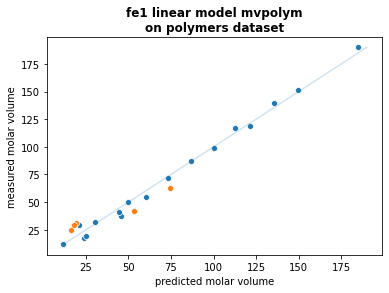

In [34]:
# plotting results with custom function
plot_results(y_mvpolym, y_hat_mvpolym, df_mvpolym_fe1['polymer'], 5,
             'fe1 linear model mvpolym\non polymers dataset', 'predicted molar volume', 'measured molar volume')

### Linear model mv trained on organic liquids to predict polymer molar volume

In [36]:
X_mvpolym2 = df_mvpolym_fe1.drop(['M', 'type', 'polymer', 'measured_mv', 'measured_mv_scaled', 'ru']+features_exclude, axis=1)
y_hat_mvpolym2 = pd.Series(lm_mv.predict(X_mvpolym2), index=X_mvpolym2.index)
regression_results(y_hat_mvpolym2, df_mvpolym_fe1['measured_mv_scaled'])

explained_variance:  0.6808
mean_squared_log_error:  0.7046
r2:  -0.7425
MAE:  45.3819
MSE:  2521.3353
RMSE:  50.2129


                         name      y       y_hat
10    poly(butyl vinyl ether)  54.40  132.141584
6       poly(4-methylstyrene)  62.60  137.450323
14  poly(methyl methacrylate)  42.05  112.707884
5                 polystyrene  50.00  119.697075
8             poly(1-pentene)  41.25  110.087894


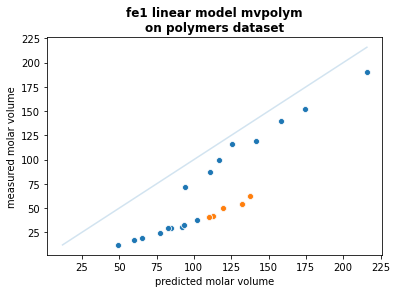

In [37]:
# plotting results with custom function
plot_results(y_mvpolym, y_hat_mvpolym2, df_mvpolym_fe1['polymer'], 5,
             'fe1 linear model mvpolym\non polymers dataset', 'predicted molar volume', 'measured molar volume')

### Linear model mv trained on organic liquids to predict polymer molar volume (polyester only)

In [39]:
df_mvpolym_polyester_fe1 = df_mvpolym_fe1[df_mvpolym_fe1['type'] == 'polyester']
X_mvpolym3 = (df_mvpolym_polyester_fe1
              .drop(['M', 'type', 'polymer', 'measured_mv', 'measured_mv_scaled', 'ru']+features_exclude, axis=1))
y_hat_mvpolym3 = pd.Series(lm_mv.predict(X_mvpolym3), index=X_mvpolym3.index)
regression_results(y_hat_mvpolym3, df_mvpolym_polyester_fe1['measured_mv_scaled'])

explained_variance:  0.982
mean_squared_log_error:  0.0297
r2:  0.684
MAE:  20.2055
MSE:  432.9271
RMSE:  20.8069


Empty DataFrame
Columns: [name, y, y_hat]
Index: []


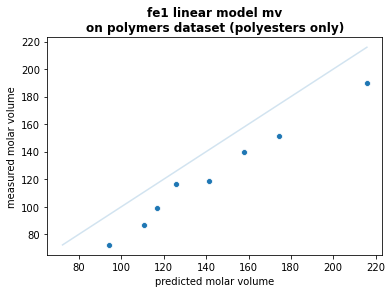

In [40]:
# plotting results with custom function
plot_results(df_mvpolym_polyester_fe1['measured_mv_scaled'], y_hat_mvpolym3, df_mvpolym_polyester_fe1['polymer'], 0,
             'fe1 linear model mv\non polymers dataset (polyesters only)', 'predicted molar volume', 'measured molar volume')